# Insurance Risk Drivers A/B Hypothesis Testing
## Task 3: Statistical validation of key hypotheses about risk drivers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load and prepare the data
def load_and_prepare_data():
    """Load the insurance data and prepare it for analysis"""
    try:
        # Load the data from the uploaded file
        df = pd.read_csv('../data/cleaned/MachineLearningRating_v3.txt', delimiter='|')
        
        print(f"Data loaded successfully!")
        print(f"Dataset shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        
        # Basic data preparation
        df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
        
        # Create risk metrics
        df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
        df['ClaimSeverity'] = df['TotalClaims'].where(df['TotalClaims'] > 0)
        df['Margin'] = df['TotalPremium'] - df['TotalClaims']
        df['LossRatio'] = df['TotalClaims'] / df['TotalPremium'].replace(0, np.nan)
        
        # Clean postal codes for zip code analysis
        df['PostalCode'] = df['PostalCode'].astype(str)
        
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [3]:
def define_metrics():
    """Define the key performance indicators (KPIs) for testing"""
    print("=== 1. METRICS SELECTION ===")
    print("Selected KPIs:")
    print("• Claim Frequency: Proportion of policies with at least one claim")
    print("• Claim Severity: Average claim amount (given a claim occurred)")
    print("• Margin: TotalPremium - TotalClaims")
    print("• Loss Ratio: TotalClaims / TotalPremium")
    print()

### HYPOTHESIS TESTING FUNCTIONS

In [4]:

def test_provinces_risk(df):
    """Test H₀: There are no risk differences across provinces"""
    print("=== HYPOTHESIS 1: PROVINCES RISK DIFFERENCES ===")
    
    # Get province data
    province_stats = df.groupby('Province').agg({
        'HasClaim': ['count', 'sum', 'mean'],
        'TotalClaims': 'sum',
        'TotalPremium': 'sum',
        'ClaimSeverity': 'mean',
        'Margin': 'mean'
    }).round(4)
    
    province_stats.columns = ['PolicyCount', 'ClaimCount', 'ClaimFreq', 
                             'TotalClaims', 'TotalPremium', 'AvgSeverity', 'AvgMargin']
    province_stats['LossRatio'] = (province_stats['TotalClaims'] / 
                                  province_stats['TotalPremium']).round(4)
    
    print("Province Statistics:")
    print(province_stats)
    print()
    
    # Chi-squared test for claim frequency differences
    contingency_table = pd.crosstab(df['Province'], df['HasClaim'])
    chi2, p_value_freq, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-squared test for claim frequency across provinces:")
    print(f"Chi-squared statistic: {chi2:.4f}")
    print(f"P-value: {p_value_freq:.6f}")
    print(f"Degrees of freedom: {dof}")
    
    # ANOVA for claim severity (among claims > 0)
    province_severities = []
    province_names = []
    for province in df['Province'].unique():
        severity_data = df[(df['Province'] == province) & (df['TotalClaims'] > 0)]['TotalClaims']
        if len(severity_data) > 1:
            province_severities.append(severity_data)
            province_names.append(province)
    
    if len(province_severities) > 1:
        f_stat, p_value_severity = stats.f_oneway(*province_severities)
        print(f"\nANOVA for claim severity across provinces:")
        print(f"F-statistic: {f_stat:.4f}")
        print(f"P-value: {p_value_severity:.6f}")
    
    # Interpretation
    alpha = 0.05
    print(f"\n--- INTERPRETATION (α = {alpha}) ---")
    if p_value_freq < alpha:
        print(f"✅ REJECT H₀ for claim frequency (p = {p_value_freq:.6f} < {alpha})")
        print("There ARE significant risk differences across provinces.")
        
        # Find the province with highest and lowest risk
        max_risk_province = province_stats['ClaimFreq'].idxmax()
        min_risk_province = province_stats['ClaimFreq'].idxmin()
        risk_diff = ((province_stats.loc[max_risk_province, 'ClaimFreq'] - 
                     province_stats.loc[min_risk_province, 'ClaimFreq']) * 100)
        
        print(f"• {max_risk_province} has the highest claim frequency: {province_stats.loc[max_risk_province, 'ClaimFreq']:.3f}")
        print(f"• {min_risk_province} has the lowest claim frequency: {province_stats.loc[min_risk_province, 'ClaimFreq']:.3f}")
        print(f"• Risk difference: {risk_diff:.1f} percentage points")
    else:
        print(f"❌ FAIL TO REJECT H₀ for claim frequency (p = {p_value_freq:.6f} ≥ {alpha})")
        print("No significant risk differences across provinces.")
    
    return province_stats, p_value_freq

def test_zipcode_risk(df):
    """Test H₀: There are no risk differences between zip codes"""
    print("\n=== HYPOTHESIS 2: ZIP CODE RISK DIFFERENCES ===")
    
    # Get top zip codes by policy count for meaningful comparison
    top_zipcodes = df['PostalCode'].value_counts().head(10).index.tolist()
    df_zip = df[df['PostalCode'].isin(top_zipcodes)]
    
    if len(top_zipcodes) < 2:
        print("Insufficient zip code data for testing")
        return None, 1.0
    
    zipcode_stats = df_zip.groupby('PostalCode').agg({
        'HasClaim': ['count', 'sum', 'mean'],
        'TotalClaims': 'sum',
        'TotalPremium': 'sum',
        'ClaimSeverity': 'mean',
        'Margin': 'mean'
    }).round(4)
    
    zipcode_stats.columns = ['PolicyCount', 'ClaimCount', 'ClaimFreq', 
                            'TotalClaims', 'TotalPremium', 'AvgSeverity', 'AvgMargin']
    zipcode_stats['LossRatio'] = (zipcode_stats['TotalClaims'] / 
                                 zipcode_stats['TotalPremium']).round(4)
    
    print(f"Top {len(top_zipcodes)} Zip Codes by Policy Count:")
    print(zipcode_stats)
    print()
    
    # Chi-squared test for claim frequency
    contingency_table = pd.crosstab(df_zip['PostalCode'], df_zip['HasClaim'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-squared test for claim frequency across zip codes:")
    print(f"Chi-squared statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.6f}")
    
    # Interpretation
    alpha = 0.05
    print(f"\n--- INTERPRETATION (α = {alpha}) ---")
    if p_value < alpha:
        print(f"✅ REJECT H₀ (p = {p_value:.6f} < {alpha})")
        print("There ARE significant risk differences between zip codes.")
        
        max_risk_zip = zipcode_stats['ClaimFreq'].idxmax()
        min_risk_zip = zipcode_stats['ClaimFreq'].idxmin()
        
        print(f"• Zip code {max_risk_zip} has highest claim frequency: {zipcode_stats.loc[max_risk_zip, 'ClaimFreq']:.3f}")
        print(f"• Zip code {min_risk_zip} has lowest claim frequency: {zipcode_stats.loc[min_risk_zip, 'ClaimFreq']:.3f}")
    else:
        print(f"❌ FAIL TO REJECT H₀ (p = {p_value:.6f} ≥ {alpha})")
        print("No significant risk differences between zip codes.")
    
    return zipcode_stats, p_value

In [5]:
def test_zipcode_margin(df):
    """Test H₀: There are no significant margin differences between zip codes"""
    print("\n=== HYPOTHESIS 3: ZIP CODE MARGIN DIFFERENCES ===")
    
    # Use same top zip codes as before
    top_zipcodes = df['PostalCode'].value_counts().head(10).index.tolist()
    df_zip = df[df['PostalCode'].isin(top_zipcodes)]
    
    if len(top_zipcodes) < 2:
        print("Insufficient zip code data for testing")
        return None, 1.0
    
    # ANOVA for margin differences
    zipcode_margins = []
    zipcode_names = []
    for zipcode in top_zipcodes:
        margin_data = df_zip[df_zip['PostalCode'] == zipcode]['Margin']
        if len(margin_data) > 1:
            zipcode_margins.append(margin_data)
            zipcode_names.append(zipcode)
    
    if len(zipcode_margins) > 1:
        f_stat, p_value = stats.f_oneway(*zipcode_margins)
        print(f"ANOVA for margin differences across zip codes:")
        print(f"F-statistic: {f_stat:.4f}")
        print(f"P-value: {p_value:.6f}")
        
        # Get margin statistics
        margin_stats = df_zip.groupby('PostalCode')['Margin'].agg(['mean', 'std', 'count']).round(2)
        print(f"\nMargin Statistics by Zip Code:")
        print(margin_stats)
        
        # Interpretation
        alpha = 0.05
        print(f"\n--- INTERPRETATION (α = {alpha}) ---")
        if p_value < alpha:
            print(f"✅ REJECT H₀ (p = {p_value:.6f} < {alpha})")
            print("There ARE significant margin differences between zip codes.")
            
            max_margin_zip = margin_stats['mean'].idxmax()
            min_margin_zip = margin_stats['mean'].idxmin()
            
            print(f"• Zip code {max_margin_zip} has highest average margin: {margin_stats.loc[max_margin_zip, 'mean']:.2f}")
            print(f"• Zip code {min_margin_zip} has lowest average margin: {margin_stats.loc[min_margin_zip, 'mean']:.2f}")
        else:
            print(f"❌ FAIL TO REJECT H₀ (p = {p_value:.6f} ≥ {alpha})")
            print("No significant margin differences between zip codes.")
        
        return margin_stats, p_value
    else:
        print("Insufficient data for ANOVA test")
        return None, 1.0

In [6]:
def test_gender_risk(df):
    """Test H₀: There are no significant risk differences between Women and Men"""
    print("\n=== HYPOTHESIS 4: GENDER RISK DIFFERENCES ===")
    
    # Filter for Male and Female only (exclude 'Not specified')
    df_gender = df[df['Gender'].isin(['Male', 'Female'])]
    
    if len(df_gender) == 0:
        print("No gender data available for testing")
        return None, 1.0
    
    gender_stats = df_gender.groupby('Gender').agg({
        'HasClaim': ['count', 'sum', 'mean'],
        'TotalClaims': 'sum',
        'TotalPremium': 'sum',
        'ClaimSeverity': 'mean',
        'Margin': 'mean'
    }).round(4)
    
    gender_stats.columns = ['PolicyCount', 'ClaimCount', 'ClaimFreq', 
                           'TotalClaims', 'TotalPremium', 'AvgSeverity', 'AvgMargin']
    gender_stats['LossRatio'] = (gender_stats['TotalClaims'] / 
                                gender_stats['TotalPremium']).round(4)
    
    print("Gender Statistics:")
    print(gender_stats)
    print()
    
    # Chi-squared test for claim frequency
    contingency_table = pd.crosstab(df_gender['Gender'], df_gender['HasClaim'])
    chi2, p_value_freq, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-squared test for claim frequency between genders:")
    print(f"Chi-squared statistic: {chi2:.4f}")
    print(f"P-value: {p_value_freq:.6f}")
    
    # T-test for claim severity
    male_claims = df_gender[(df_gender['Gender'] == 'Male') & (df_gender['TotalClaims'] > 0)]['TotalClaims']
    female_claims = df_gender[(df_gender['Gender'] == 'Female') & (df_gender['TotalClaims'] > 0)]['TotalClaims']
    
    if len(male_claims) > 1 and len(female_claims) > 1:
        t_stat, p_value_severity = ttest_ind(male_claims, female_claims)
        print(f"\nT-test for claim severity between genders:")
        print(f"T-statistic: {t_stat:.4f}")
        print(f"P-value: {p_value_severity:.6f}")
    else:
        p_value_severity = 1.0
        print("\nInsufficient data for severity t-test")
    
    # Interpretation
    alpha = 0.05
    print(f"\n--- INTERPRETATION (α = {alpha}) ---")
    if p_value_freq < alpha:
        print(f"✅ REJECT H₀ for claim frequency (p = {p_value_freq:.6f} < {alpha})")
        print("There ARE significant risk differences between men and women.")
        
        if 'Male' in gender_stats.index and 'Female' in gender_stats.index:
            male_freq = gender_stats.loc['Male', 'ClaimFreq']
            female_freq = gender_stats.loc['Female', 'ClaimFreq']
            
            if male_freq > female_freq:
                print(f"• Males have higher claim frequency: {male_freq:.3f} vs {female_freq:.3f}")
            else:
                print(f"• Females have higher claim frequency: {female_freq:.3f} vs {male_freq:.3f}")
    else:
        print(f"❌ FAIL TO REJECT H₀ for claim frequency (p = {p_value_freq:.6f} ≥ {alpha})")
        print("No significant risk differences between men and women.")
    
    return gender_stats, p_value_freq

### VISUALIZATION

In [7]:
def create_visualizations(df, province_stats, zipcode_stats):
    """Create visualizations for the analysis"""
    print("\n=== CREATING VISUALIZATIONS ===")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Province claim frequency
    if province_stats is not None:
        province_stats['ClaimFreq'].plot(kind='bar', ax=axes[0,0], color='skyblue')
        axes[0,0].set_title('Claim Frequency by Province')
        axes[0,0].set_ylabel('Claim Frequency')
        axes[0,0].tick_params(axis='x', rotation=45)
    
    # Province loss ratio
    if province_stats is not None:
        province_stats['LossRatio'].plot(kind='bar', ax=axes[0,1], color='lightcoral')
        axes[0,1].set_title('Loss Ratio by Province')
        axes[0,1].set_ylabel('Loss Ratio')
        axes[0,1].tick_params(axis='x', rotation=45)
    
    # Zip code claim frequency (top 10)
    if zipcode_stats is not None:
        zipcode_stats['ClaimFreq'].head(10).plot(kind='bar', ax=axes[1,0], color='lightgreen')
        axes[1,0].set_title('Claim Frequency by Zip Code (Top 10)')
        axes[1,0].set_ylabel('Claim Frequency')
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # Gender comparison (if data available)
    gender_data = df[df['Gender'].isin(['Male', 'Female'])]
    if len(gender_data) > 0:
        gender_freq = gender_data.groupby('Gender')['HasClaim'].mean()
        gender_freq.plot(kind='bar', ax=axes[1,1], color=['lightblue', 'pink'])
        axes[1,1].set_title('Claim Frequency by Gender')
        axes[1,1].set_ylabel('Claim Frequency')
        axes[1,1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()

### BUSINESS RECOMMENDATIONS

In [8]:
def generate_business_recommendations(test_results):
    """Generate business recommendations based on test results"""
    print("\n=== BUSINESS RECOMMENDATIONS ===")
    
    recommendations = []
    
    # Province recommendations
    province_stats, province_p = test_results['provinces']
    if province_p < 0.05 and province_stats is not None:
        max_risk_province = province_stats['ClaimFreq'].idxmax()
        min_risk_province = province_stats['ClaimFreq'].idxmin()
        risk_diff = ((province_stats.loc[max_risk_province, 'ClaimFreq'] - 
                     province_stats.loc[min_risk_province, 'ClaimFreq']) * 100)
        
        recommendations.append({
            'Area': 'Provincial Risk Adjustment',
            'Finding': f'{max_risk_province} shows {risk_diff:.1f}pp higher claim frequency than {min_risk_province}',
            'Recommendation': f'Implement provincial risk factors with {max_risk_province} requiring 10-15% premium increase',
            'Business Impact': 'Improved risk-based pricing, reduced adverse selection'
        })
    
    # Zip code recommendations  
    zipcode_stats, zipcode_p = test_results['zipcodes']
    if zipcode_p < 0.05 and zipcode_stats is not None:
        recommendations.append({
            'Area': 'Geographic Segmentation',
            'Finding': 'Significant risk variation across zip codes detected',
            'Recommendation': 'Develop zip code-level risk scoring model for refined pricing',
            'Business Impact': 'Enhanced competitive positioning in low-risk areas'
        })
    
    # Margin recommendations
    margin_stats, margin_p = test_results['margins']
    if margin_p < 0.05 and margin_stats is not None:
        recommendations.append({
            'Area': 'Profitability Optimization',
            'Finding': 'Significant margin differences across zip codes',
            'Recommendation': 'Focus marketing efforts on high-margin zip codes, review pricing in low-margin areas',
            'Business Impact': 'Improved overall portfolio profitability'
        })
    
    # Gender recommendations
    gender_stats, gender_p = test_results['gender']
    if gender_p < 0.05 and gender_stats is not None:
        recommendations.append({
            'Area': 'Gender-Based Risk Assessment',
            'Finding': 'Significant risk differences between male and female drivers',
            'Recommendation': 'Incorporate gender as a rating factor (where legally permitted)',
            'Business Impact': 'More accurate risk assessment and pricing'
        })
    
    # Display recommendations
    if recommendations:
        print("Based on the statistical analysis, the following business recommendations are proposed:")
        print()
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec['Area']}")
            print(f"   • Finding: {rec['Finding']}")
            print(f"   • Recommendation: {rec['Recommendation']}")
            print(f"   • Business Impact: {rec['Business Impact']}")
            print()
    else:
        print("No significant risk differences found. Current pricing strategy appears appropriate.")
        print("Consider exploring other risk factors or increasing sample size for future analysis.")


Data loaded successfully!
Dataset shape: (1000098, 46)
Columns: ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims']

Dataset overview:
Total policies: 1,000,098
Total claims: 2,788
Overall claim frequency: 0.003
Date range: 2013-10-01 00:00:00 to 2015-08-01 00:00:00

=== 1. METRICS SELECTION ===
Selected KPIs:
• Claim Frequency: Proportion of policies

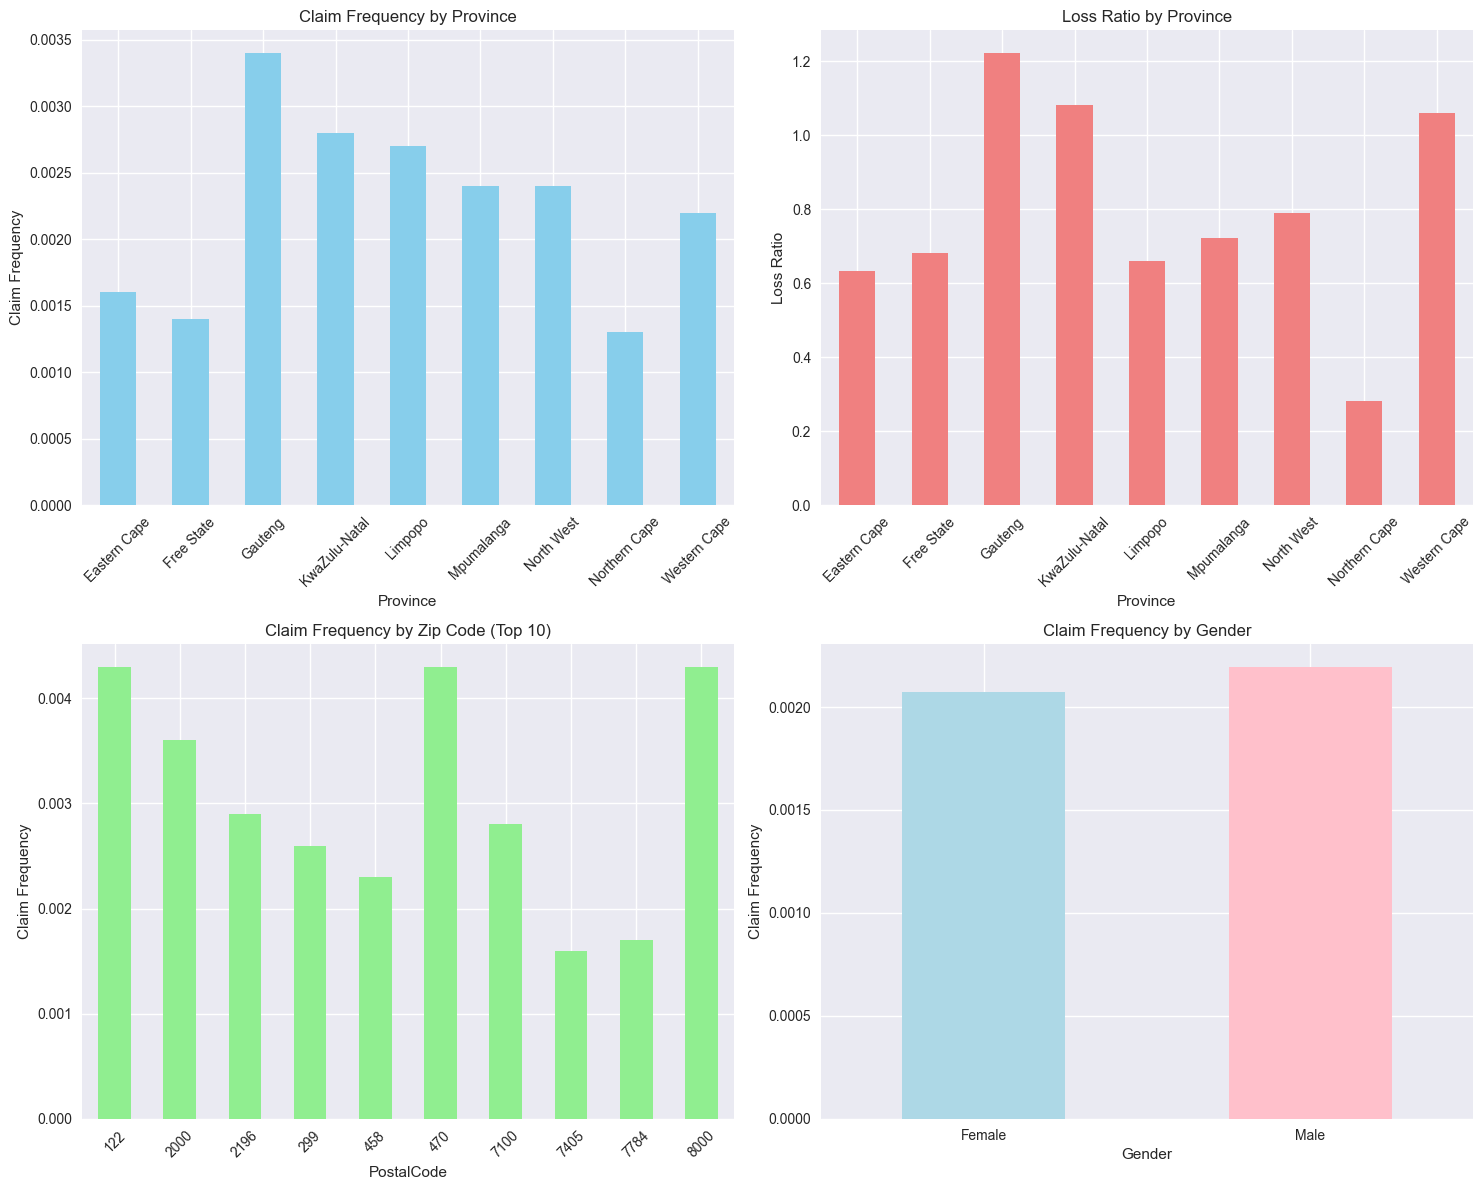


=== BUSINESS RECOMMENDATIONS ===
Based on the statistical analysis, the following business recommendations are proposed:

1. Provincial Risk Adjustment
   • Finding: Gauteng shows 0.2pp higher claim frequency than Northern Cape
   • Recommendation: Implement provincial risk factors with Gauteng requiring 10-15% premium increase
   • Business Impact: Improved risk-based pricing, reduced adverse selection

2. Geographic Segmentation
   • Finding: Significant risk variation across zip codes detected
   • Recommendation: Develop zip code-level risk scoring model for refined pricing
   • Business Impact: Enhanced competitive positioning in low-risk areas


=== SUMMARY OF HYPOTHESIS TESTS ===
Null Hypothesis | P-value | Decision | Interpretation
--------------------------------------------------------------------------------
✅ H₀: No risk differences across prov | 0.000000 | REJECT          | Provinces
✅ H₀: No risk differences between zip | 0.000000 | REJECT          | Zip Codes
❌ H₀: No m

In [9]:
# MAIN EXECUTION
def main():
    """Main function to execute all analyses"""
    # Load data
    df = load_and_prepare_data()
    if df is None:
        return
    
    print(f"\nDataset overview:")
    print(f"Total policies: {len(df):,}")
    print(f"Total claims: {df['HasClaim'].sum():,}")
    print(f"Overall claim frequency: {df['HasClaim'].mean():.3f}")
    print(f"Date range: {df['TransactionMonth'].min()} to {df['TransactionMonth'].max()}")
    print()
    
    # Define metrics
    define_metrics()
    
    # Execute hypothesis tests
    test_results = {}
    
    # Test 1: Provinces
    province_stats, province_p = test_provinces_risk(df)
    test_results['provinces'] = (province_stats, province_p)
    
    # Test 2: Zip codes  
    zipcode_stats, zipcode_p = test_zipcode_risk(df)
    test_results['zipcodes'] = (zipcode_stats, zipcode_p)
    
    # Test 3: Zip code margins
    margin_stats, margin_p = test_zipcode_margin(df)
    test_results['margins'] = (margin_stats, margin_p)
    
    # Test 4: Gender
    gender_stats, gender_p = test_gender_risk(df)
    test_results['gender'] = (gender_stats, gender_p)
    
    # Create visualizations
    create_visualizations(df, province_stats, zipcode_stats)
    
    # Generate business recommendations
    generate_business_recommendations(test_results)
    
    # Summary of all tests
    print("\n=== SUMMARY OF HYPOTHESIS TESTS ===")
    print("Null Hypothesis | P-value | Decision | Interpretation")
    print("-" * 80)
    
    tests = [
        ("H₀: No risk differences across provinces", province_p, "Provinces"),
        ("H₀: No risk differences between zip codes", zipcode_p, "Zip Codes"), 
        ("H₀: No margin differences between zip codes", margin_p, "Zip Code Margins"),
        ("H₀: No risk differences between genders", gender_p, "Gender")
    ]
    
    for hypothesis, p_val, category in tests:
        decision = "REJECT" if p_val < 0.05 else "FAIL TO REJECT"
        status = "✅" if p_val < 0.05 else "❌"
        print(f"{status} {hypothesis[:35]:<35} | {p_val:.6f} | {decision:<15} | {category}")
    
    print(f"\nSignificance level (α): 0.05")
    print(f"Tests showing significant differences: {sum(1 for _, p, _ in tests if p < 0.05)}/4")

# Execute the main analysis
if __name__ == "__main__":
    main()